## Imports

In [ ]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import sklearn
from itertools import product
import math

## Variables

### Define U, S and J matrices




In [ ]:
# Truth table

# A B C
# 0 0 0
# 0 1 1
# 1 0 1
# 1 1 0

# Magnetisation

#  A  B  C
# -1 -1 -1
# -1  1  1
#  1 -1  1
#  1  1 -1

# Define truth table and with handle bits for U
U = np.array([[1,-1,-1,-1],
              [1,-1,1,1],
              [1,1,-1,1],
              [1,1,1,-1]])

nr_aux_bits = 4
J_width = nr_aux_bits+4
count = 0

# find values for the auxiliary bits
for vals in product([0, 1], repeat=4*nr_aux_bits):
  # get new configuration of binary array
  arr = np.array(vals).reshape((4, nr_aux_bits))

  # tranform zeros into -1
  for i in range(nr_aux_bits):
    for j in range(nr_aux_bits):
      if arr[i][j] == 0:
        arr[i][j] = -1

  # concatinate the random array with U
  new_U = np.concatenate((arr.T, U.T)).T
  UU = np.dot(new_U, new_U.T)

  # see if U*UT is an identity matrix
  is_id = True
  for i in range(nr_aux_bits):
    for j in range(nr_aux_bits):
      if UU[i][j] != 0 and i != j:
        is_id = False

  # if it is an identity matrix then save and break
  if is_id:
    count += 1
    if count >= 2: # for some reason not all of them work, but this one does? 2, 3, 4, 5, 6, 7, 10, the're all slightly different but they all work.
      U = new_U
      break

# The fact that not all of them work probably has something to do with this from the paper:
# Another important aspect in the construction of [J] is that an eigenvector ui implies that its complement −ui is also a valid eigenvector
print("U-matrix: ")
print(U)
# calculate J
J = np.zeros((J_width,J_width))
for i in range(nr_aux_bits):
  Ui = np.array([U[i]])
  J += np.dot(Ui.T, Ui).T

J = J/2

# put zeros in the diagonal of J
for i in range(J_width):
  for j in range(J_width):
    if i == j:
      J[i][j] = 0

print("\nJ-matrix: ")
print(J)

U-matrix: 
[[-1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1  1  1  1 -1  1  1]
 [-1  1 -1  1  1  1 -1  1]
 [ 1 -1 -1  1  1  1  1 -1]]

J-matrix: 
[[ 0.  0.  0.  0. -1.  1.  1. -1.]
 [ 0.  0.  0.  0. -1.  1. -1.  1.]
 [ 0.  0.  0.  0. -1. -1.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.]
 [-1. -1. -1.  1.  0.  0.  0.  0.]
 [ 1.  1. -1.  1.  0.  0.  0.  0.]
 [ 1. -1.  1.  1.  0.  0.  0.  0.]
 [-1.  1.  1.  1.  0.  0.  0.  0.]]


In [ ]:
random.seed(123) # setting the seed of rng for reproducibility
NM = 8 # number of p-bits in the system

# J matrix (should be symmetrical)
# J = np.array([[0,-1,0,0,1,1,1,0],
#               [-1,0,1,1,0,0,0,1],
#               [0,1,0,0,1,1,-1,0],
#               [0,1,0,0,1,-1,1,0],
#               [1,0,1,1,0,0,0,-1],
#               [1,0,1,-1,0,0,0,1],
#               [1,0,-1,1,0,0,0,1],
#               [0,1,0,0,-1,1,1,0]])

# h vector (a column vector)
h = np.zeros((NM, 1))

# initial state of the spins (randomly chosen)
m = np.array([-1, 1, -1])

NT = 10000  # Number of samples (10000 might be too little, since this results in some variability between the exact and probablistic values)
beta = 1    # inverse temperature = 1/kT
            # where T is absolute temperature
            # and k is Boltzmann constant

Pr = np.zeros(2**NM) # placeholder for sampled probability: for 3 pbits, there are 2^3 = 8 states
Pe = np.zeros(2**NM) # placeholder for exact probability: for 3 pbits, there are 2^3 = 8 states

Look = [2**i for i in range(7, -1, -1)] # bin identifier vector

# initializing energy --- extra
E = np.zeros(NT)

### two spin p bit

## Exact Boltzmann benchmark

In [ ]:
if NM < 12: # exact calculation is expensive, so we will do it only for small systems

    for ii in range(0, 2**NM): # each of the NM variables has two states, thus the system has 2^NM states in total
        # look up the documentation of de2bi function
        # generates a state of the spins
        binary_str = np.binary_repr(ii, width=NM)
        m = (2 * np.array(list(binary_str), dtype=np.int8) - 1) # scaling to -1 and 1.

        # compute the energy of the system for the given states of spins
        E[ii] = -0.5 * m.T @ J @ m + h.T @ m

        # probability of given state is proportional to exp(-beta*E)
        Pe[ii] = np.exp(-beta * E[ii])

# Normalize probabilities
Pe = Pe / np.sum(Pe)

## Probabilistic simulation

In [ ]:
Pr = np.zeros(2**NM)
for ii in range(0, NT): # samples loop
    for jj in range(0, NM): # update all the spins one by one sequentially

        # synapse equation for jj-th pbit
        I = np.dot(J[jj, :], m) + h[jj]
        # neuron equation for jj-th pbit
        m[jj] = np.sign(np.tanh(beta * I) - 2 * random.random() + 1)

    # when we have updated all the spins at once we get one sample
    # given a state of the spins find out the bin number in the 2^NM space
    kk = 1 + np.dot(Look, (1 + m) / 2)

    # increment the corresponding bin
    Pr[int(kk)-1] += 1

# Normalize probabilities
Pr = Pr / np.sum(Pr)

## Plotting

In [ ]:
#only get the last 3 spins, so 8 values.
Pe3 = np.zeros(8)
Pr3 = np.zeros(8)

# normalise over A, B and C
for i in range(len(Pe)):
    binary_str = np.binary_repr(i, width=NM)
    handle_bit = binary_str[0]
    new_binary_str = binary_str[-3:] # last 3 bits (ABC)
    new_index = int(new_binary_str, 2) # convert binary to int

    if handle_bit == '1': # only add if handle bit is 1
      Pe3[new_index] += Pe[i]
      Pr3[new_index] += Pr[i]

# re-normalise probabilities
Pr = Pr3 / np.sum(Pr3)
Pe = Pe3 / np.sum(Pe3)

NameError: ignored

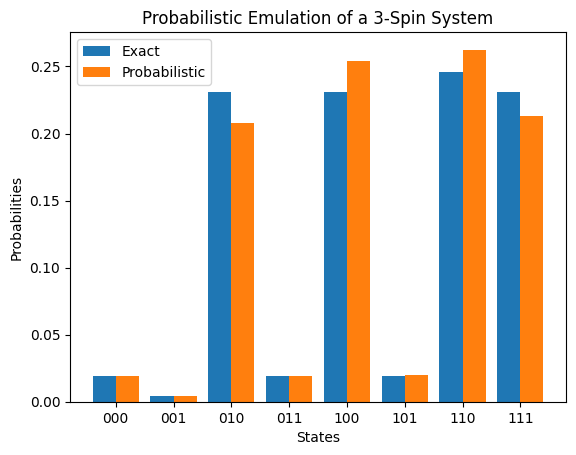

In [ ]:
x_positions = np.arange(len(Pe))
width = 0.4  # Adjust the width as needed
labels = ["000", "001", "010", "011", "100", "101", "110", "111"]

plt.figure()
plt.bar(x_positions - width/2, Pe, width, label='Exact')
plt.bar(x_positions + width/2, Pr, width, label='Probabilistic')
plt.xticks(x_positions, labels)
plt.xlabel('States')
plt.ylabel('Probabilities')
plt.legend()
plt.title('Probabilistic Emulation of a 3-Spin System')
plt.show()

In [ ]:
def sample(input_spins, Pr):
  input_string = str(input_spins[0]) + str(input_spins[1])
  possible_strings = [input_string+"0", input_string+"1"]
  possible_ints = [int(i, 2) for i in possible_strings]

  highest_pr = 0
  for i in possible_ints:
    if Pr[i] > highest_pr:
      highest_pr = i

  highest_string = np.binary_repr(highest_pr, width=int(math.sqrt(len(Pr)))) # any leading zero's disappear because of this, but this is no problem
  output = int(highest_string[-1])

  return output

sample([0, 1], Pr3)

0

In [ ]:
def sample_spins(Pr):
  value = np.random.choice(range(0,len(Pr)), size=1, p=Pr)
  output = np.binary_repr(value[0], width=int(math.sqrt(len(Pr))))

  while len(output) < 3:
    output = "0" + output

  return output

sample_spins(Pr)

'010'

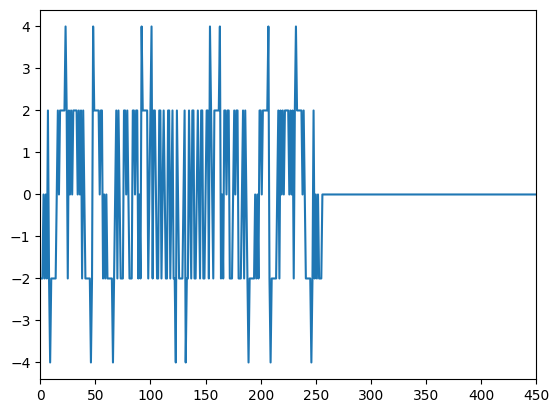

In [ ]:
plt.plot(range(0, len(E)), E)
plt.xlim((0, 450))
plt.show()


# Hopfield network

In [ ]:
def update_weight(states):
  # concatenate into a matrix with each state as one column of this matrix
  states_matrix = np.column_stack(states)
  # this will compute the sum of the outer products of each column vectors
  # in the matrix, which are the given states
  weight = states_matrix.T @ states_matrix
  # zero out the diagonal (there are no self-recurrent connections in Hopfield
  # networks)
  np.fill_diagonal(weight, 0)
  print(weight)
  return weight


In [ ]:
# s1 =0
# s2 =0
# s3 =1
# s4 = 1
# #initial states
# init_state = np.array([[s1, s2, s3, s4],[s1,s2,s3, -s4]])

# # xor truth tables magnetised important to keep this way
# state_1 = np.array([1, 1,-1, 1])
# state_4 = np.array([1, -1, 1, 1])
# state_2 = np.array([ 1, 1, 1, -1])
# state_3 = np.array([ -1, -1, -1, -1])
# # xor truth table
# state_1c = np.array([1, 1,0, 1])
# state_4c = np.array([1, 0, 1, 1])
# state_2c = np.array([ 1, 1, 1, 0])
# state_3c = np.array([ 0, 0, 0, 0])

# memory_states = (state_1, state_2, state_3, state_4)
# cmemory_states = (state_1c, state_2c, state_3c, state_4c)
# beta=1
# l=0
# E = np.zeros(NT)
# Pe=np.zeros(NT)
# # test numerous configurations of incomplete data
# for l in range(1):
#   # 4 memory states for XOR gate
#   for k in range(len(memory_states)):
#     # initialise parameters
#     weight = update_weight(memory_states[k])
#     x=init_state[l] # any (in)complete vector
#     y = x
#     # loop over all bits in the incomplete vector
#     for i in range(len(x)):
#       label= False
#       # update absolute value of yi
#       y[i] =x[i] + y@weight[:,i]
#       # activation 'function' over yi
#       if y[i] > 0 :
#         y[i] = 1
#       elif y[i]<0:
#         y[i] =0
#       # check if converged
#       if np.all(y== cmemory_states[k]):

#         print('yaaaay', y, '==', cmemory_states[k])
#         label = True
#         break

#     if label:
#       print("Let's celebrate! Found a match in memory state of:", memory_states[k])
#       break
#     print('oops did not find a match in memory state of:', memory_states[k])
#   # compute energy
#   E[l] = -0.5 * y.T @ weight @ y

#   # probability of given state is proportional to exp(-beta*E)
#   Pe[l] = np.exp(-beta * E[l])
#   # iterate over energy functopn
# # Normalize probabilities
# Pe = Pe / np.sum(Pe)

oops did not find a match in memory state of: [ 1  1 -1  1]
oops did not find a match in memory state of: [ 1  1  1 -1]
oops did not find a match in memory state of: [-1 -1 -1 -1]
yaaaay [1 0 1 1] == [1 0 1 1]
Let's celebrate! Found a match in memory state of: [ 1 -1  1  1]


https://www.geeksforgeeks.org/hopfield-neural-network/

## Hopfield with methods

In [ ]:
def activation_func(y):
  # activation 'function' over yi
  if y > 0 :
    y = 1
  elif y<0:
    y =0
  return y

In [ ]:
def compute(x, memory_states, cmemory_states, label = False):
  # 4 memory states for XOR gate
  for k in range(len(memory_states)):
    # initialise weight and y
    weight = update_weight(memory_states[k])
    y = x
    # loop over all bits in the incomplete vector
    for i in range(len(x)):
      # update absolute value of yi
      y[i] = activation_func(x[i] + y@weight[:,i])
      # check if converged
      if np.all(y== cmemory_states[k]):
        print('\nyaaaay', y, '==', cmemory_states[k])
        label = True
        break
    if label:
      print("Let's celebrate! Found a match in memory state of:", memory_states[k])
      break
    print('oops did not find a match in memory state of:', memory_states[k])
  return y, weight

In [ ]:
## 4 bit
#binary rep
# s1 =1
# s2 =1
# s3 =1
# s4 = 1
# #initial states
# init_state = np.array([[s1, s2, s3, s4],[s1,s2,s3, -s4]])
import numpy as np
# xor truth tables magnetised important to keep this way
state_1 = np.array([1, 1,-1, 1])
state_4 = np.array([1, -1, 1, 1])
state_2 = np.array([ 1, 1, 1, -1])
state_3 = np.array([ -1, -1, -1, -1])
# xor truth table
state_1c = np.array([1, 1,0, 1])
state_4c = np.array([1, 0, 1, 1])
state_2c = np.array([ 1, 1, 1, 0])
state_3c = np.array([ 0, 0, 0, 0])


In [ ]:
## 8 bit
# xor truth tables magnetised important to keep this way
state_1 = np.array([1, 1, 1, 1,1, 1,-1, 1])
state_4 = np.array([1, 1, 1, 1,1, -1, 1, 1])
state_2 = np.array([1, 1, 1, 1,1, 1, 1, -1])
state_3 = np.array([1, 1, 1, 1,1, -1, -1, -1])
# xor truth table
state_1c = np.array([1, 1, 1, 1,1, 1,0, 1])
state_4c = np.array([1, 1, 1, 1,1, 0, 1, 1])
state_2c = np.array([1, 1, 1, 1, 1, 1, 1, 0])
state_3c = np.array([1, 1, 1, 1, 0, 0, 0, 0])


In [ ]:
# memory_states = U
# cmemory_states = np.where(U==-1, 0, 1)
memory_states = [state_1, state_2, state_3, state_4]
cmemory_states = [state_1c, state_2c, state_3c, state_4c]
beta=1
NM=8
NT=1000
E_hopfield = np.zeros(NT)
Pe_hopfield = np.zeros(2**NM)
weights=[]
if NM < 12: # exact calculation is expensive, so we will do it only for small systems

    for ii in range(0, 2**NM): # each of the NM variables has two states, thus the system has 2^NM states in total
        print('----------------------------------------------------\n iteration', ii+1)
        # look up the documentation of de2bi function
        # generates a state of the spins
        binary_str = np.binary_repr(ii, width=NM)
        x = np.array(list(binary_str),dtype=np.int8)
        # x=init_state[l] # any (in)complete vector
        y, weight = compute(x, memory_states, cmemory_states)
        weights.append(weight)
        # compute energy

        E_hopfield[ii] = -0.5 * y.T @ weight @ y
        # probability of given state is proportional to exp(-beta*E)
        Pe_hopfield[ii] = np.exp(-beta * E_hopfield[ii])
  # iterate over energy function
# Normalize probabilities
Pe_hopfield = Pe_hopfield / np.sum(Pe_hopfield)


In [ ]:
weight=update_weight(memory_states )

[[0 4 4 4 4 0 0 0]
 [4 0 4 4 4 0 0 0]
 [4 4 0 4 4 0 0 0]
 [4 4 4 0 4 0 0 0]
 [4 4 4 4 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


## Plotting

In [ ]:
#only get the last 3 spins, so 8 values.
Pe3_hopfield = np.zeros(8)
# normalise over A, B and C
for i in range(len(Pe_hopfield)):
    binary_str = np.binary_repr(i, width=NM)
    handle_bit = binary_str[4]
    new_binary_str = binary_str[-3:] # last 3 bits (ABC)
    new_index = int(new_binary_str, 2) # convert binary to int

    if handle_bit == '1': # only add if handle bit is 1
        Pe3_hopfield[new_index] += Pe_hopfield[i]

# re-normalise probabilities
Pe_hopfield = Pe3_hopfield / np.sum(Pe3_hopfield)


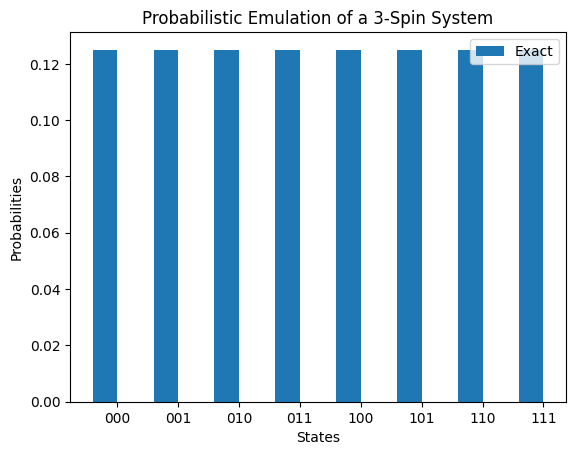

In [ ]:
x_positions = np.arange(len(Pe_hopfield))
width = 0.4  # Adjust the width as needed
labels = ["000", "001", "010", "011", "100", "101", "110", "111"]

plt.figure()
plt.bar(x_positions - width/2, Pe_hopfield, width, label='Exact')
plt.xticks(x_positions, labels)
plt.xlabel('States')
plt.ylabel('Probabilities')
plt.legend()
plt.title('Probabilistic Emulation of a 3-Spin System')
plt.show()

(0.0, 50.0)

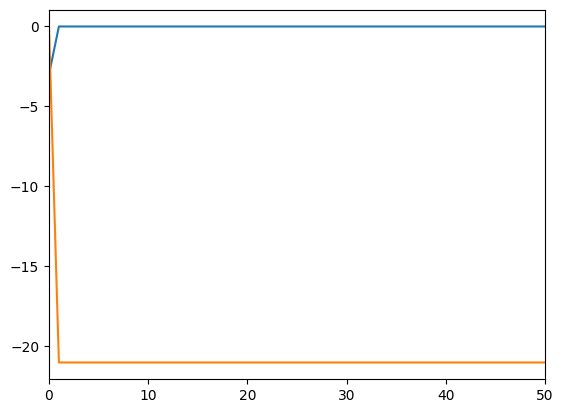

In [ ]:
plt.plot(range(0, len(E)), E)
plt.plot(range(0, len(E_hopfield)), E_hopfield)
plt.xlim((0,50))

# Pbit

In [ ]:
memory_states = U
cmemory_states = np.where(U==-1, 0, 1)
# memory_states = [state_1, state_2, state_3, state_4]
# cmemory_states = [state_1c, state_2c, state_3c, state_4c]
beta=1
NM=8
NT=1000
E_hopfield = np.zeros(NT)
Pe_hopfield = np.zeros(2**NM)
if NM < 12: # exact calculation is expensive, so we will do it only for small systems

    for ii in range(0, 2**NM): # each of the NM variables has two states, thus the system has 2^NM states in total
        print('----------------------------------------------------\n iteration', ii+1)
        # look up the documentation of de2bi function
        # generates a state of the spins
        binary_str = np.binary_repr(ii, width=NM)
        x = np.array(list(binary_str),dtype=np.int8)
        # x=init_state[l] # any (in)complete vector
        y, weight = compute(x, memory_states, cmemory_states)
        # compute energy

        E_hopfield[ii] = -0.5 * y.T @ weight @ y
        # probability of given state is proportional to exp(-beta*E)
        Pe_hopfield[ii] = np.exp(-beta * E_hopfield[ii])
  # iterate over energy function
# Normalize probabilities
Pe_hopfield = Pe_hopfield / np.sum(Pe_hopfield)


----------------------------------------------------
 iteration 1
oops did not find a match in memory state of: [-1 -1 -1 -1  1 -1 -1  1]
oops did not find a match in memory state of: [-1  1  1  1  1 -1  1  1]
oops did not find a match in memory state of: [ 1 -1  1  1  1  1 -1  1]
oops did not find a match in memory state of: [-1 -1  1 -1  1  1  1 -1]
----------------------------------------------------
 iteration 2

yaaaay [0 0 0 0 1 0 0 1] == [0 0 0 0 1 0 0 1]
Let's celebrate! Found a match in memory state of: [-1 -1 -1 -1  1 -1 -1  1]
----------------------------------------------------
 iteration 3
oops did not find a match in memory state of: [-1 -1 -1 -1  1 -1 -1  1]

yaaaay [0 1 1 1 1 0 1 1] == [0 1 1 1 1 0 1 1]
Let's celebrate! Found a match in memory state of: [-1  1  1  1  1 -1  1  1]
----------------------------------------------------
 iteration 4
oops did not find a match in memory state of: [-1 -1 -1 -1  1 -1 -1  1]

yaaaay [0 1 1 1 1 0 1 1] == [0 1 1 1 1 0 1 1]
Let's cel

In [ ]:
#only get the last 3 spins, so 8 values.
Pe3_hopfield = np.zeros(8)
# normalise over A, B and C
for i in range(len(Pe_hopfield)):
    binary_str = np.binary_repr(i, width=NM)
    handle_bit = binary_str[4]
    new_binary_str = binary_str[-3:] # last 3 bits (ABC)
    new_index = int(new_binary_str, 2) # convert binary to int

    if handle_bit == '1': # only add if handle bit is 1
        Pe3_hopfield[new_index] += Pe_hopfield[i]

# re-normalise probabilities
Pe_hopfield = Pe3_hopfield / np.sum(Pe3_hopfield)


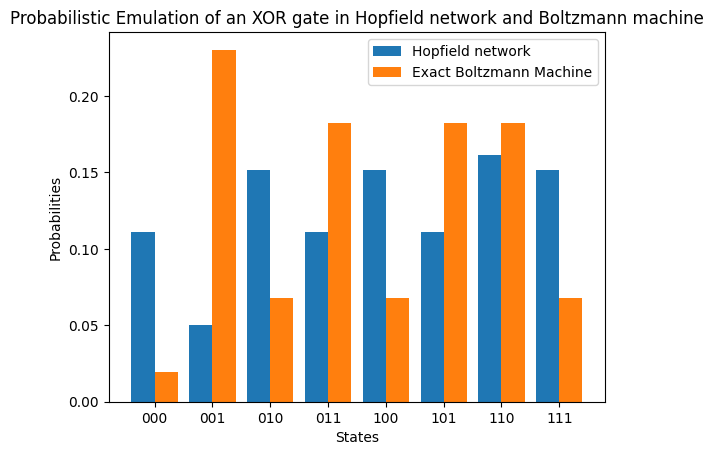

In [ ]:
x_positions = np.arange(len(Pe_hopfield))
width = 0.4  # Adjust the width as needed
labels = ["000", "001", "010", "011", "100", "101", "110", "111"]

plt.figure()
plt.bar(x_positions - width/2, Pe_hopfield, width, label='Hopfield network')
plt.bar(x_positions + width/2, Pe, width, label='Exact Boltzmann Machine')
plt.xticks(x_positions, labels)
plt.xlabel('States')
plt.ylabel('Probabilities')
plt.legend()
plt.title('Probabilistic Emulation of an XOR gate in Hopfield network and Boltzmann machine')
plt.show()

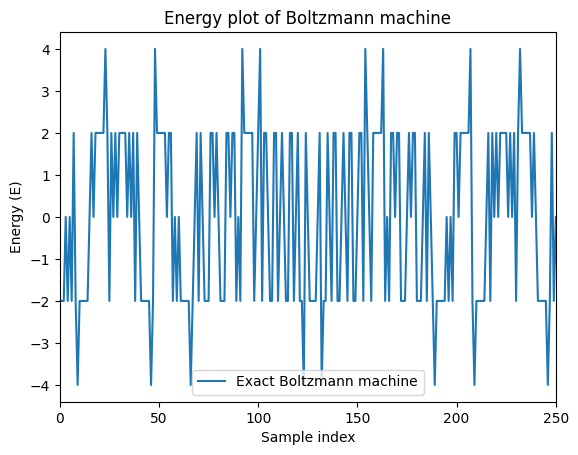

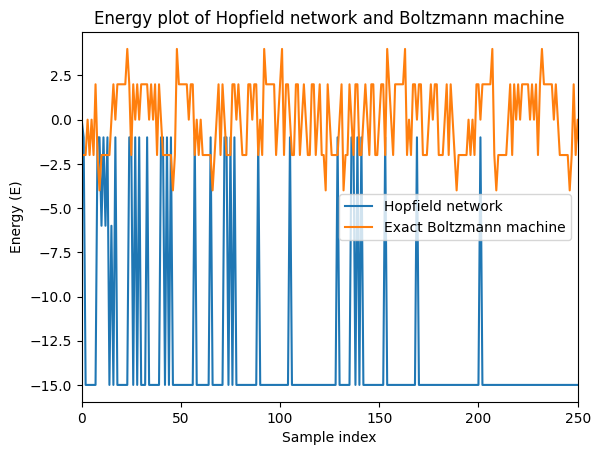

In [ ]:
plt.plot(range(0, len(E)), E, label = 'Exact Boltzmann machine')
plt.xlim((0,250))
plt.ylabel('Energy (E)')
plt.xlabel('Sample index')
plt.title('Energy plot of Boltzmann machine')
plt.legend()
plt.show()
plt.plot(range(0, len(E_hopfield)), E_hopfield, label = 'Hopfield network')
plt.plot(range(0, len(E)), E, label = 'Exact Boltzmann machine')
plt.xlim((0,250))
plt.ylabel('Energy (E)')
plt.xlabel('Sample index')
plt.title('Energy plot of Hopfield network and Boltzmann machine')
plt.legend()
plt.show()